# Jute Pest Classification with a Simple CNN

This notebook downloads the UCI Jute Pest dataset, builds a TensorFlow data pipeline, trains a small CNN, and evaluates performance.

- Dataset: https://archive.ics.uci.edu/dataset/920/jute+pest+dataset
- Classes: 17
- Splits: train / val / test (provided by dataset)
- Framework: TensorFlow/Keras (from .cnn_env)


In [1]:
# Environment check
import sys, platform, os
import tensorflow as tf
print("Python:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU'))>0)


Python: 3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Platform: Windows-11-10.0.26200-SP0
TensorFlow: 2.16.1
Keras: 3.12.0
GPU available: False


In [2]:
# Imports and constants
import os
from pathlib import Path
import shutil
import zipfile
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

# Paths
ROOT = Path.cwd()
DATA_DIR = ROOT / "DataSets" / "jute_pest"
ZIP_PATH = DATA_DIR / "jute_pest_dataset.zip"
EXTRACT_DIR = DATA_DIR / "Jute_Pest_Dataset"
DOWNLOAD_URL = "https://archive.ics.uci.edu/static/public/920/jute+pest+dataset.zip"

# Training params
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
SEED = 42
NUM_WORKERS = os.cpu_count() or 4

DATA_DIR.mkdir(parents=True, exist_ok=True)
print("Data root:", DATA_DIR)


Data root: d:\Python-Universe\neural_networks\DataSets\jute_pest


In [3]:
# Download and extract the dataset (id=920)
import urllib.request

if not ZIP_PATH.exists():
    print("Downloading:", DOWNLOAD_URL)
    t0 = time.time()
    try:
        urllib.request.urlretrieve(DOWNLOAD_URL, ZIP_PATH)
    except Exception as e:
        raise RuntimeError(f"Failed to download dataset: {e}")
    print(f"Downloaded to {ZIP_PATH} in {time.time()-t0:.1f}s, size={(ZIP_PATH.stat().st_size/1e6):.1f} MB")
else:
    print("Zip already exists:", ZIP_PATH)

# Extract if needed
if not EXTRACT_DIR.exists():
    print("Extracting to:", EXTRACT_DIR)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_DIR)
    # Normalize possible folder names after extraction
    # Find the folder that contains 'train' subfolder
    candidates = [p for p in DATA_DIR.iterdir() if p.is_dir()]
    chosen = None
    for c in candidates:
        if (c / 'train').exists() and (c / 'val').exists():
            chosen = c
            break
    if chosen and chosen != EXTRACT_DIR:
        EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
        # Move contents inside chosen into EXTRACT_DIR
        for item in chosen.iterdir():
            target = EXTRACT_DIR / item.name
            if target.exists():
                continue
            shutil.move(str(item), str(target))
        # Remove the old folder if empty
        try:
            chosen.rmdir()
        except OSError:
            pass
    print("Extraction complete.")
else:
    print("Data already extracted:", EXTRACT_DIR)

# Show basic structure
for split in ["train", "val", "test"]:
    split_dir = EXTRACT_DIR / split
    print(f"\nSplit: {split} ->", split_dir)
    if split_dir.exists():
        classes = sorted([d.name for d in split_dir.iterdir() if d.is_dir()])
        print("Classes (", len(classes), "):", classes)
        # Count a few samples
        total = 0
        for cls in classes[:5]:
            n = len(list((split_dir/cls).glob("*.jpg"))) + len(list((split_dir/cls).glob("*.png")))
            print(f"  {cls}: ~{n} images (first 5 classes shown)")
            total += n
        print("  ...")
    else:
        print("  Not provided in archive.")


Downloading: https://archive.ics.uci.edu/static/public/920/jute+pest+dataset.zip


KeyboardInterrupt: 

In [4]:
# Build TensorFlow datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = EXTRACT_DIR / 'train'
val_dir = EXTRACT_DIR / 'val'
test_dir = EXTRACT_DIR / 'test'

if not train_dir.exists():
    raise FileNotFoundError(f"Expected train directory at {train_dir} after extraction.")

train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',  # use integers for sparse categorical crossentropy
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED)

val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False) if val_dir.exists() else None

test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False) if test_dir.exists() else None

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes (", num_classes, "):", class_names)

# Performance optimizations
AUTOTUNE = tf.data.AUTOTUNE

def prep(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prep(train_ds, training=True)
val_ds = prep(val_ds) if val_ds is not None else None
test_ds = prep(test_ds) if test_ds is not None else None


Found 6443 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.
Found 379 files belonging to 17 classes.
Classes ( 17 ): ['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']
Classes ( 17 ): ['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']


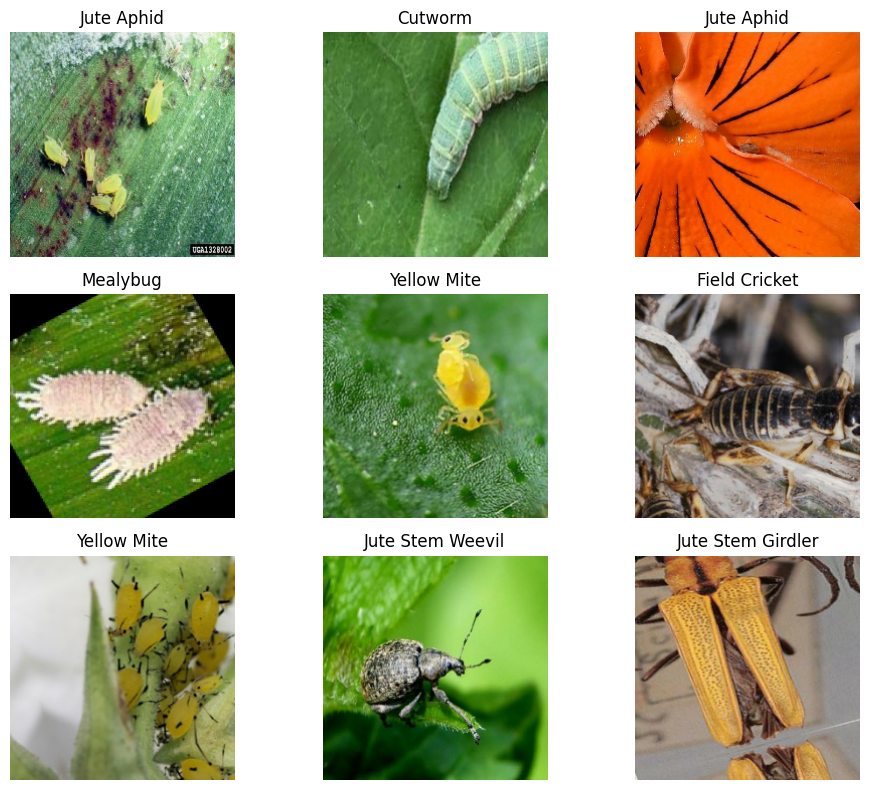

In [5]:
# Visualize a few training images
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [6]:
# Data augmentation and model definition

data_augmentation = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augment")

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)

# A small CNN suitable for quick training
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='jute_cnn')
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()


Model: "jute_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,787,985 (98.37 MB)

 Trainable params: 25,787,985 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 84s 405ms/step - accuracy: 0.2286 - loss: 2.4748 - val_accuracy: 0.3535 - val_loss: 2.1466
Epoch 2/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 84s 405ms/step - accuracy: 0.2286 - loss: 2.4748 - val_accuracy: 0.3535 - val_loss: 2.1466
Epoch 2/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - accuracy: 0.4372 - loss: 1.7645 - val_accuracy: 0.5085 - val_loss: 1.9364
Epoch 3/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - accuracy: 0.4372 - loss: 1.7645 - val_accuracy: 0.5085 - val_loss: 1.9364
Epoch 3/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 83s 413ms/step - accuracy: 0.5587 - loss: 1.3943 - val_accuracy: 0.5182 - val_loss: 1.8596
Epoch 4/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 83s 413ms/step - accuracy: 0.5587 - loss: 1.3943 - val_accuracy: 0.5182 - val_loss: 1.8596
Epoch 4/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 83s 412ms/step - accuracy: 0.6342 - loss: 1.1548 - val_accuracy: 0.5908 - val_loss: 1.8373
Epoch 5/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 81s 401ms/step - accuracy: 0.7087 - loss: 0.9203 - 

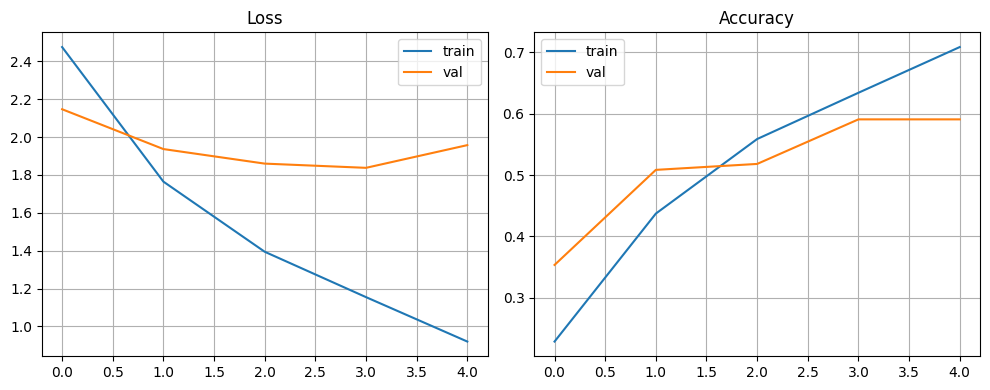

In [7]:
# Train
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot training curves
hist = history.history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train')
if 'val_loss' in hist: plt.plot(hist['val_loss'], label='val')
plt.title('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train')
if 'val_accuracy' in hist: plt.plot(hist['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


                               precision    recall  f1-score   support

                Beet Armyworm       0.38      0.40      0.39        20
                  Black Hairy       0.69      0.55      0.61        20
                      Cutworm       0.67      0.20      0.31        20
                Field Cricket       0.39      0.45      0.42        20
                   Jute Aphid       0.50      0.50      0.50        22
                   Jute Hairy       0.48      0.55      0.51        20
                Jute Red Mite       0.45      0.83      0.59        24
              Jute Semilooper       0.92      0.57      0.71        21
            Jute Stem Girdler       0.87      0.83      0.85        24
             Jute Stem Weevil       0.48      0.62      0.55        24
                  Leaf Beetle       0.66      0.79      0.72        24
                     Mealybug       0.61      0.58      0.60        24
                    Pod Borer       0.79      0.62      0.70        24
     

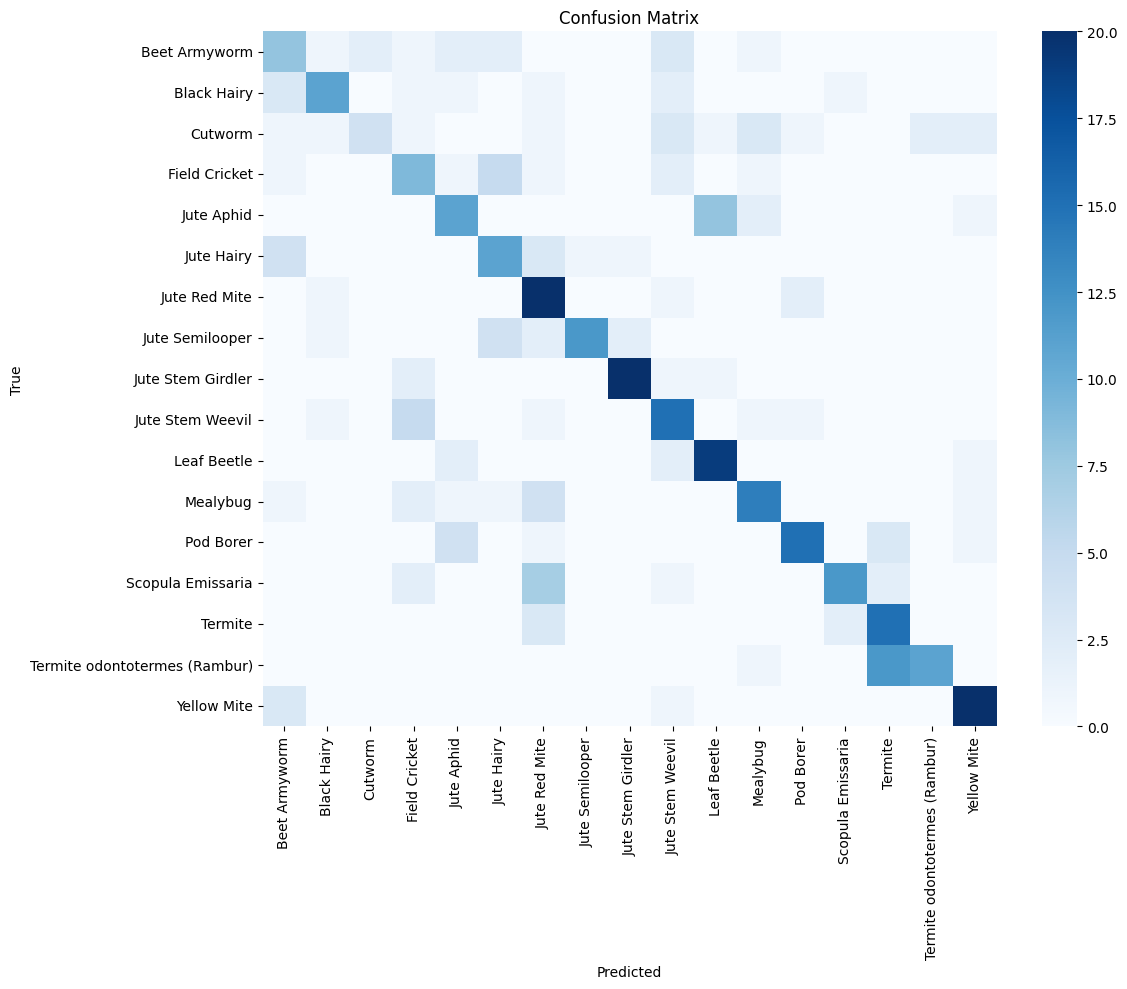

In [8]:
# Evaluate and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

eval_ds = test_ds if test_ds is not None else val_ds
if eval_ds is None:
    print("No validation or test split found; skipping evaluation.")
else:
    y_true = []
    y_pred = []
    for batch_images, batch_labels in eval_ds:
        preds = model.predict(batch_images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(batch_labels.numpy().tolist())

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


Saved model to: d:\Python-Universe\neural_networks\models\jute_cnn.keras


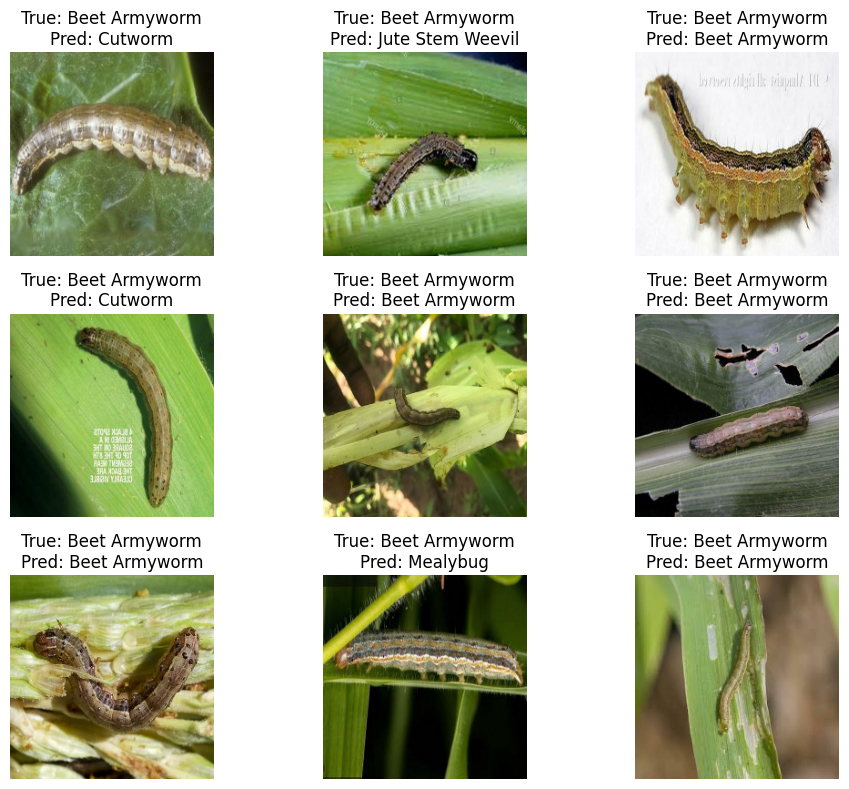

In [9]:
# Save model and sample prediction
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODEL_DIR / "jute_cnn.keras"
model.save(MODEL_PATH)
print("Saved model to:", MODEL_PATH)

# Show a few predictions
for images, labels in (test_ds or val_ds).take(1):
    preds = model.predict(images, verbose=0)
    top = np.argmax(preds, axis=1)
    plt.figure(figsize=(10,8))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"True: {class_names[int(labels[i])] }\nPred: {class_names[int(top[i])]}")
        plt.axis('off')
    plt.tight_layout(); plt.show()


In [10]:
# Load saved model (optional) or use in-memory model
from pathlib import Path

MODEL_DIR = ROOT / "models"
MODEL_PATH = MODEL_DIR / "jute_cnn.keras"

loaded = False
if 'model' in globals() and hasattr(model, 'predict'):
    print("Model already in memory; keeping current model.")
elif MODEL_PATH.exists():
    print("Loading model from:", MODEL_PATH)
    model = keras.models.load_model(MODEL_PATH)
    loaded = True
else:
    raise FileNotFoundError(f"No model in memory and not found at {MODEL_PATH}. Please run training cell first.")

print("Classes (num=", len(class_names), "):\n", class_names)


Model already in memory; keeping current model.
Classes (num= 17 ):
 ['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']


In [11]:
# Evaluate on validation set
if val_ds is None:
    print("Validation dataset not available; skipping.")
else:
    val_loss, val_acc = model.evaluate(val_ds, verbose=1)
    print(f"Validation - loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

    # Detailed report
    y_true, y_pred = [], []
    for x, y in val_ds:
        p = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(p, axis=1))
        y_true.extend(y.numpy().tolist())

    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=class_names))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5908 - loss: 1.8373
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5908 - loss: 1.8373
Validation - loss: 1.8373, accuracy: 0.5908
Validation - loss: 1.8373, accuracy: 0.5908
                               precision    recall  f1-score   support

                Beet Armyworm       0.64      0.40      0.49        40
                  Black Hairy       0.82      0.47      0.60        30
                      Cutworm       0.33      0.11      0.17        18
                Field Cricket       0.38      0.57      0.46        14
                   Jute Aphid       0.53      0.33      0.41        27
                   Jute Hairy       0.12      0.38      0.19         8
                Jute Red Mite       0.74      0.71      0.73        49
              Jute Semilooper       0.33      0.20      0.25         5
            Jute Stem Girdler       0.71      0.83      0.77         6
             Jute Stem Weevil       0.65      0.82   

In [12]:
# Evaluate on test set
if test_ds is None:
    print("Test dataset not available; skipping.")
else:
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print(f"Test - loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

    # Detailed report
    y_true, y_pred = [], []
    for x, y in test_ds:
        p = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(p, axis=1))
        y_true.extend(y.numpy().tolist())

    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5989 - loss: 1.1940
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5989 - loss: 1.1940
Test - loss: 1.1940, accuracy: 0.5989
Test - loss: 1.1940, accuracy: 0.5989
                               precision    recall  f1-score   support

                Beet Armyworm       0.38      0.40      0.39        20
                  Black Hairy       0.69      0.55      0.61        20
                      Cutworm       0.67      0.20      0.31        20
                Field Cricket       0.39      0.45      0.42        20
                   Jute Aphid       0.50      0.50      0.50        22
                   Jute Hairy       0.48      0.55      0.51        20
                Jute Red Mite       0.45      0.83      0.59        24
              Jute Semilooper       0.92      0.57      0.71        21
            Jute Stem Girdler       0.87      0.83      0.85        24
             Jute Stem Weevil       0.48      0.62      0.55     

In [13]:
# Single-image inference helper
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(img_path: str):
    """Load an image, run the model, and return (pred_idx, pred_name, probs)."""
    img = load_img(img_path, target_size=IMG_SIZE)
    arr = img_to_array(img)  # 0-255 float32
    batch = np.expand_dims(arr, axis=0)  # shape (1, H, W, 3)
    probs = model.predict(batch, verbose=0)[0]
    idx = int(np.argmax(probs))
    return idx, class_names[idx], probs

# Demo: pick one image from test (or val) and predict
base = test_dir if test_dir.exists() else val_dir
if base.exists():
    any_class = sorted([d for d in base.iterdir() if d.is_dir()])[0]
    any_image = sorted(list(any_class.glob('*.jpg')) + list(any_class.glob('*.png')))[0]
    idx, name, probs = predict_image(str(any_image))
    print("Image:", any_image)
    print("Pred:", idx, name)
else:
    print("No test/val directory found for demo inference.")


Image: d:\Python-Universe\neural_networks\DataSets\jute_pest\Jute_Pest_Dataset\test\Beet Armyworm\image-49-_jpg.rf.bea68748bdba49337aa703c27ddcfed4.jpg
Pred: 9 Jute Stem Weevil


# 📈 How to increase accuracy (overview)

Strategies you can apply (implemented below):
- Use transfer learning (MobileNetV2 pretrained on ImageNet)
- Improve data augmentation (flip/rotate/zoom; brightness/contrast)
- Handle class imbalance with class weights
- Train longer with a learning-rate schedule, then fine-tune upper base layers
- Use label smoothing to regularize


In [ ]:
# Class distribution and class weights (to handle imbalance)
from collections import Counter

train_counts = {}
if (EXTRACT_DIR / 'train').exists():
    for cls in class_names:
        n = len(list((EXTRACT_DIR / 'train' / cls).glob('*.jpg'))) + len(list((EXTRACT_DIR / 'train' / cls).glob('*.png')))
        train_counts[cls] = n
else:
    # fallback using dataset batches (coarse)
    c = Counter()
    for _, y in train_ds.take(50):  # sample batches for speed
        for yy in y.numpy().tolist():
            c[int(yy)] += 1
    for i, cls in enumerate(class_names):
        train_counts[cls] = c[i]

print('Train counts by class:')
for k in class_names:
    print(f'  {k}: {train_counts.get(k, 0)}')

total = sum(train_counts.values())
num_classes = len(class_names)
class_weight = {i: (total / (num_classes * (train_counts.get(cls, 1) or 1))) for i, cls in enumerate(class_names)}
print('\nDerived class_weight mapping (index -> weight):')
print(class_weight)


In [ ]:
# Transfer learning model: MobileNetV2 (faster + often higher accuracy)
from keras import applications

# Data augmentation tuned for transfer learning (no Rescaling here)
tl_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(factor=0.1),
], name="tl_augment")

base = applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3)
)
base.trainable = False  # freeze backbone for initial training

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = tl_augmentation(inputs)
# Preprocess to [-1, 1] as expected by MobileNetV2
x = applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

tl_model = keras.Model(inputs, outputs, name='jute_mobilenetv2')
tl_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)
tl_model.summary()


In [ ]:
# Train transfer model (frozen backbone) with LR schedule and class weights
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

initial_epochs = 10

tl_history = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

# Save and set as active model for downstream cells
MODEL_DIR = ROOT / 'models'
MODEL_DIR.mkdir(exist_ok=True)
TL_MODEL_PATH = MODEL_DIR / 'jute_mobilenetv2.keras'
tl_model.save(TL_MODEL_PATH)
print('Saved transfer model to:', TL_MODEL_PATH)

# Use this model for the later evaluation/prediction cells
model = tl_model


In [ ]:
# Fine-tune: unfreeze top layers of the base model
# Unfreeze a portion (e.g., top 30%) for fine-tuning
fine_tune_at = int(len(base.layers) * 0.7)
base.trainable = True
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile with a lower LR
tl_model.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

fine_tune_epochs = 10
fine_history = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ],
    class_weight=class_weight,
    verbose=1
)

# Save fine-tuned model
FT_MODEL_PATH = MODEL_DIR / 'jute_mobilenetv2_finetuned.keras'
tl_model.save(FT_MODEL_PATH)
print('Saved fine-tuned model to:', FT_MODEL_PATH)

# Keep using the fine-tuned model
model = tl_model
